In [1]:
# === QuickDraw classifier + simple DCGAN augmentation (PyTorch) ===
# Run this in Google Colab (GPU recommended).
# Change CLASSES below to pick the 10 classes you want.

# 1) Install / import
!pip install --quiet wget ndjson

import os, time, math, random, wget, io
from urllib.request import urlopen
from io import BytesIO
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as T
import torchvision.utils as vutils
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


  Preparing metadata (setup.py) ... done
Device: cpu


In [2]:
# 2) Choose your 10 classes (edit this list if you want others)
CLASSES = [
 "apple","banana","car","cat","dog","house","tree","bicycle","fish","chair"
]
# Save to file for reference (Flask can load this file)
os.makedirs('data', exist_ok=True)
with open('data/classes.txt','w') as f:
    f.write("\n".join(CLASSES))

In [3]:
# 3) Download a modest subset per class (adjust examples_per_class)
examples_per_class = 2000   # how many sketches per class to download (reduce if slow)
out_dir = Path('data')
for cls in CLASSES:
    fname = out_dir / f"{cls}.npy"
    if not fname.exists():
        url = f"https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{cls}.npy"
        print("Downloading", cls)
        wget.download(url, str(fname))
    else:
        print(cls, "already downloaded.")

In [4]:
# 4) Load .npy, sample subset, preprocess
def load_class_np(cls, n_examples):
    arr = np.load(str(out_dir / f"{cls}.npy"))
    if n_examples and n_examples < len(arr):
        idx = np.random.choice(len(arr), n_examples, replace=False)
        arr = arr[idx]
    # arr shape: (N, 784), values 0..255; convert to float32 0..1
    arr = arr.astype('float32')/255.0
    arr = arr.reshape((-1, 1, 28, 28))  # channel-first grayscale
    return arr

X_list, y_list = [], []
for i,cls in enumerate(CLASSES):
    arr = load_class_np(cls, examples_per_class)
    X_list.append(arr)
    y_list.append(np.full((arr.shape[0],), i, dtype=np.int64))

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)
print("Total images:", X.shape, "labels:", y.shape)


Total images: (20000, 1, 28, 28) labels: (20000,)


In [5]:
# 5) Train / val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (17000, 1, 28, 28) Val: (3000, 1, 28, 28)


In [6]:
# 6) PyTorch Dataset wrapper
class QuickDrawDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        img = self.X[idx]  # shape (1,28,28)
        label = int(self.y[idx])
        img = torch.from_numpy(img)  # tensor float32
        if self.transform:
            img = self.transform(img)
        # print(f'Index {idx} transformed image shape: {img.shape}')
        return img, label

# optional augmentation for classifier training
train_transform = T.Compose([
    T.Resize((28,28)),
    # inputs are tensors (C,H,W) in 0..1
    T.RandomAffine(degrees=15, translate=(0.08,0.08), shear=8),
    T.RandomHorizontalFlip(),
    # normalize to (-1,1) for tanh based GAN compatibility
    T.Normalize((0.5,), (0.5,))
])
val_transform = T.Compose([
    T.Resize((28,28)),
    T.Normalize((0.5,), (0.5,))
])

train_ds = QuickDrawDataset(X_train, y_train, transform=train_transform)
val_ds = QuickDrawDataset(X_val, y_val, transform=val_transform)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [7]:

# 7) Define a small CNN classifier
class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  # 7x7
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, n_classes)
        )
    def forward(self,x):
        x = self.net(x)
        x = self.classifier(x)
        return x

clf = SimpleCNN(len(CLASSES)).to(device)



In [8]:
# 8) Train helper
def train_classifier(model, train_loader, val_loader, epochs=6, lr=1e-3):
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_val = 0.0
    for epoch in range(epochs):
        print("start epoch")
        model.train()
        running=0.0; n=0
        for xb,yb in train_loader:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()
            running += loss.item()*xb.size(0)
            n += xb.size(0)
        train_loss = running/n
        # val
        model.eval()
        correct=0; total=0; vloss=0.0
        with torch.no_grad():
            for xb,yb in val_loader:
                xb,yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item()*xb.size(0)
                preds = out.argmax(dim=1)
                correct += (preds==yb).sum().item()
                total += xb.size(0)
        val_loss = vloss/total
        val_acc = correct/total
        print(f"Epoch {epoch+1}/{epochs} train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")
        if val_acc>best_val:
            torch.save({
                'model_state_dict': model.state_dict(),
                'classes': CLASSES,
                'input_size': (1,28,28),
                'output_size': len(CLASSES),
                'timestamp': time.time()
            }, 'checkpoint_classifier.pth')
            best_val = val_acc
    print("Training finished. Best val acc:", best_val)


In [9]:

# 9) Define a tiny DCGAN (generator + discriminator) for 28x28 grayscale
nz = 64  # latent dim
ngf = 64
ndf = 64

class Generator(nn.Module):
    def __init__(self, nz=64, ngf=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 3, 1, 0), # -> (ngf*4,3,3)
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1), # -> (ngf*2,7,7)
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1), # -> (ngf,14,14)
            nn.BatchNorm2d(ngf), nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1), # -> (1,28,28)
            nn.Tanh()
        )
    def forward(self, z):
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1), nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 3, 1, 0), nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),  # Fixes feature map size regardless of input size
            nn.Flatten(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            n_flatten = torch.flatten(self.conv(dummy), 1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(ndf*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc[:-2](x)
        x = self.fc[-2:](x)
        return x






G = Generator(nz=nz, ngf=ngf).to(device)


D = Discriminator(ndf=ndf).to(device)


In [10]:

# 10) Train a small GAN for a short number of epochs to generate augmentations
def train_gan(G, D, data_loader, epochs=6, lr=2e-4):
    print(f"Starting GAN training for {epochs} epochs")
    criterion = nn.BCELoss()
    optD = optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))
    optG = optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
    for epoch in range(epochs):
        G.train(); D.train()
        for i,(imgs,_) in enumerate(data_loader):
            # print(f"GAN train batch img shape: {imgs.shape}")
            real = imgs.to(device)
            bs = real.size(0)
            # train D on real
            D.zero_grad()
            label_real = torch.ones(bs,1, device=device)
            out_real = D(real)
            lossD_real = criterion(out_real, label_real)
            # train D on fake
            z = torch.randn(bs, nz, 1, 1, device=device)
            fake = G(z)
            label_fake = torch.zeros(bs,1, device=device)
            out_fake = D(fake.detach())
            lossD_fake = criterion(out_fake, label_fake)
            lossD = (lossD_real + lossD_fake) * 0.5
            lossD.backward()
            optD.step()
            # train G
            G.zero_grad()
            label_g = torch.ones(bs,1, device=device) # want D to say real
            out_fake_forG = D(fake)
            lossG = criterion(out_fake_forG, label_g)
            lossG.backward()
            optG.step()
        print(f"GAN epoch {epoch+1}/{epochs} done")
    # save generator
    torch.save(G.state_dict(), "generator.pth")
    print("Saved generator.pth")

Starting GAN training for 60 epochs
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([128, 1, 28, 28])
GAN train batch img shape: torch.Size([80, 1, 28, 28])
GAN epoch 1/60 done
GAN train batch img shape: torch.Size([128, 1, 28

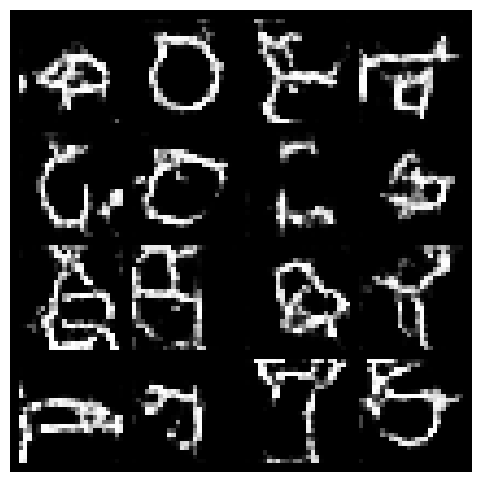

In [11]:

# 11) Run GAN training on a smaller dataset: use subset of train_ds for GAN
gan_subset = torch.utils.data.Subset(train_ds, np.random.choice(len(train_ds), min(2000,len(train_ds)), replace=False))
gan_loader = DataLoader(gan_subset, batch_size=128, shuffle=True, num_workers=2)
train_gan(G, D, gan_loader, epochs=60)  # small number to get basic shapes

# visualize some generated samples
G.eval()
with torch.no_grad():
    z = torch.randn(16, nz,1,1, device=device)
    samples = G(z).cpu() * 0.5 + 0.5  # denormalize to 0..1
    grid = vutils.make_grid(samples, nrow=4, normalize=False)
    plt.figure(figsize=(6,6)); plt.axis('off'); plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray'); plt.show()



In [14]:
# 12) Generate synthetic images and append to training set for augmentation
def generate_synthetic(G, n_per_class=200):
    G.eval()
    synth_imgs=[]; synth_labels=[]
    with torch.no_grad():
        for class_idx in range(len(CLASSES)):
            for _ in range(n_per_class):
                z = torch.randn(1, nz,1,1, device=device)
                out = G(z).cpu().numpy()  # shape (1,1,28,28) values in -1..1
                img = (out.squeeze(0).astype('float32') + 1.0)/2.0  # to 0..1
                synth_imgs.append(img)
                synth_labels.append(class_idx)
    return np.array(synth_imgs), np.array(synth_labels)

synth_X, synth_y = generate_synthetic(G, n_per_class=100)  # 100 synthetic per class => 1000 for 10 classes
print("Generated synthetic:", synth_X.shape, synth_y.shape)



Generated synthetic: (1000, 1, 24, 24) (1000,)


In [18]:
import torch.nn.functional as F

# Resize synthetic images if needed
if synth_X.shape[2] != 28 or synth_X.shape[3] != 28:
    synth_X_resized = F.interpolate(
        torch.from_numpy(synth_X), size=(28, 28), mode='bilinear', align_corners=False
    ).numpy()
else:
    synth_X_resized = synth_X

# Then use synth_X_resized for concatenation
X_train_aug = np.concatenate([X_train, synth_X_resized], axis=0)
y_train_aug = np.concatenate([y_train, synth_y], axis=0)
print("Augmented train size:", X_train_aug.shape)


Augmented train size: (18000, 1, 28, 28)


In [20]:
# 14) Train classifier with augmented data
# Re-make dataset and loader after augmentation
train_ds_aug = QuickDrawDataset(X_train_aug, y_train_aug, transform=train_transform)
train_loader_aug = DataLoader(train_ds_aug, batch_size=128, shuffle=True, num_workers=2)

clf = SimpleCNN(len(CLASSES)).to(device)
train_classifier(clf, train_loader_aug, val_loader, epochs=8, lr=1e-3)



start epoch


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/8 train_loss=1.3460 val_loss=0.7120 val_acc=0.7600
start epoch
Epoch 2/8 train_loss=0.6872 val_loss=0.3504 val_acc=0.9020
start epoch
Epoch 3/8 train_loss=0.5403 val_loss=0.3032 val_acc=0.9100
start epoch
Epoch 4/8 train_loss=0.4819 val_loss=0.2698 val_acc=0.9220
start epoch
Epoch 5/8 train_loss=0.4545 val_loss=0.2593 val_acc=0.9260
start epoch
Epoch 6/8 train_loss=0.4283 val_loss=0.2394 val_acc=0.9260
start epoch
Epoch 7/8 train_loss=0.4073 val_loss=0.2187 val_acc=0.9323
start epoch
Epoch 8/8 train_loss=0.3971 val_loss=0.2454 val_acc=0.9260
Training finished. Best val acc: 0.9323333333333333


In [21]:
# 15) Final: load best checkpoint and show example predictions
ckpt = torch.load('checkpoint_classifier.pth', map_location=device)
clf.load_state_dict(ckpt['model_state_dict'])
clf.eval()
print("Checkpoint classes:", ckpt.get('classes'))
# helper visualize one val batch
xb,yb = next(iter(val_loader))
xb = xb.to(device); yb = yb.to(device)
with torch.no_grad():
    out = clf(xb)
    preds = out.argmax(1)
print("Ground:", [CLASSES[int(x)] for x in yb[:8].cpu().numpy()])
print("Preds: ", [CLASSES[int(x)] for x in preds[:8].cpu().numpy()])



Checkpoint classes: ['apple', 'banana', 'car', 'cat', 'dog', 'house', 'tree', 'bicycle', 'fish', 'chair']
Ground: ['cat', 'house', 'dog', 'cat', 'apple', 'banana', 'banana', 'banana']
Preds:  ['cat', 'house', 'dog', 'cat', 'apple', 'banana', 'banana', 'banana']


In [22]:
# 16) Save final checkpoint with useful metadata for Flask
torch.save({
    'model_state_dict': clf.state_dict(),
    'classes': CLASSES,
    'input_size': (1,28,28),
    'output_size': len(CLASSES),
    'timestamp': time.time()
}, 'checkpoint_classifier.pth')
print("Saved checkpoint_classifier.pth with classes list.")



Saved checkpoint_classifier.pth with classes list.


In [ ]:
# 17) Flask loading snippet (use this in your run.py)
print("""
==== Flask loading snippet ====
import torch
ckpt = torch.load('checkpoint_classifier.pth', map_location='cpu')
classes = ckpt['classes']
model = SimpleCNN(len(classes))
model.load_state_dict(ckpt['model_state_dict'])
model.eval()
# when predicting, apply same preprocessing (normalize to -1..1) and run:
# x_tensor = torch.from_numpy(img).unsqueeze(0)  # shape (1,1,28,28)
# out = model(x_tensor)
# pred = out.argmax(dim=1).item()
===============================
""")